<a href="https://www.kaggle.com/code/asmaabdolahpoor/disaster-tweets-classification-nlp-bert?scriptVersionId=102865813" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import gc
import re
import string
import operator
from collections import defaultdict ,Counter

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
import seaborn as sns


from wordcloud import STOPWORDS
from nltk.util import ngrams
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

SEED = 1337

In [2]:
# sns.set_theme(style="whitegrid")
!pip install tensorflow== 2.7.1
!pip install tensorflow_hub
!pip install bert-for-tf2
!pip install sentencepiece

import tensorflow_hub as hub
import tensorflow as tf
# from bert import tokenization
from tensorflow.keras.models import Model 


ERROR: Could not find a version that satisfies the requirement tensorflow== (from versions: 0.12.1, 1.0.0, 1.0.1, 1.1.0, 1.2.0, 1.2.1, 1.3.0, 1.4.0, 1.4.1, 1.5.0, 1.5.1, 1.6.0, 1.7.0, 1.7.1, 1.8.0, 1.9.0, 1.10.0, 1.10.1, 1.11.0, 1.12.0, 1.12.2, 1.12.3, 1.13.1, 1.13.2, 1.14.0, 1.15.0, 1.15.2, 1.15.3, 1.15.4, 1.15.5, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.1.4, 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.3.0, 2.3.1, 2.3.2, 2.3.3, 2.3.4, 2.4.0, 2.4.1, 2.4.2, 2.4.3, 2.4.4, 2.5.0, 2.5.1, 2.5.2, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0, 2.6.1, 2.6.2)
ERROR: No matching distribution found for tensorflow==
     |████████████████████████████████| 51kB 1.6MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-cp36-none-any.whl size=30534 sha256=84adac72ac1d151fdee3e01dc8d8208fc9b03a3c34dc5acd5ab1efd3fc44f6d7
  Stored in directory: /root/.cache/pip/wheels/a1/04/ee/347bd9f5b821b637c76411d280271a857aece00358896a230f
  Created wheel for py-params: filename=py_params-0.10.2-cp36-n

In [3]:
import sys
sys.path.insert(1, '../input/disaster-nlp-keras-bert-using-tfhub')

import tokenization


In [4]:
df_train = pd.read_csv('../input/nlp-getting-started/train.csv')
df_test = pd.read_csv('../input/nlp-getting-started/test.csv')


In [5]:
print('df_train shape:{}'.format(df_train.shape))
print('df_train memory usage:{:.2} MB'.format(df_train.memory_usage().sum()/ 1024**2))

df_train shape:(7613, 5)
df_train memory usage:0.29 MB


In [6]:
print('df_train shape:{}'.format(df_test.shape))
print('df_train memory usage:{:.2} MB'.format(df_test.memory_usage().sum()/ 1024**2))

df_train shape:(3263, 4)
df_train memory usage:0.1 MB


In [7]:
df_test.isna().sum().values


array([   0,   26, 1105,    0])

Text(0.5, 1.0, 'Test Set')

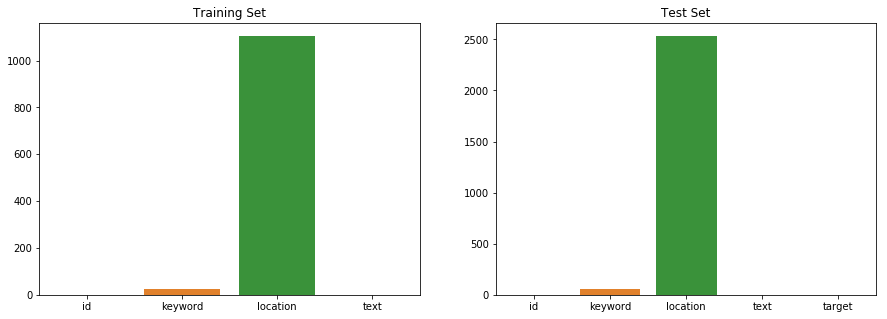

In [8]:
fig , axes=plt.subplots(ncols=2 , figsize=(15,5))
sns.barplot( x=df_test.isna().sum().index , y=df_test.isna().sum().values , ax=axes[0])
sns.barplot( x=df_train.isna().sum().index , y=df_train.isna().sum().values,ax=axes[1])
axes[0].set_title('Training Set')
axes[1].set_title('Test Set')


In [9]:
for col in ['keyword', 'location']:
    df_train[col].fillna(f'no_{col}', inplace=True)
    df_test[col].fillna(f'no_{col}', inplace=True)
    

In [10]:
df_train[df_train.keyword!='no_keyword']

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0
...,...,...,...,...,...
7578,10830,wrecked,no_location,@jt_ruff23 @cameronhacker and I wrecked you both,0
7579,10831,wrecked,"Vancouver, Canada",Three days off from work and they've pretty mu...,0
7580,10832,wrecked,London,#FX #forex #trading Cramer: Iger's 3 words tha...,0
7581,10833,wrecked,Lincoln,@engineshed Great atmosphere at the British Li...,0


In [11]:
print(np.array_equal(df_train.keyword.unique(), df_test.keyword.unique()))

True


In [12]:
# df_train.groupby('keyword').size()

In [13]:
df_train['target_mean'] = df_train.groupby('keyword')['target'].transform('mean')

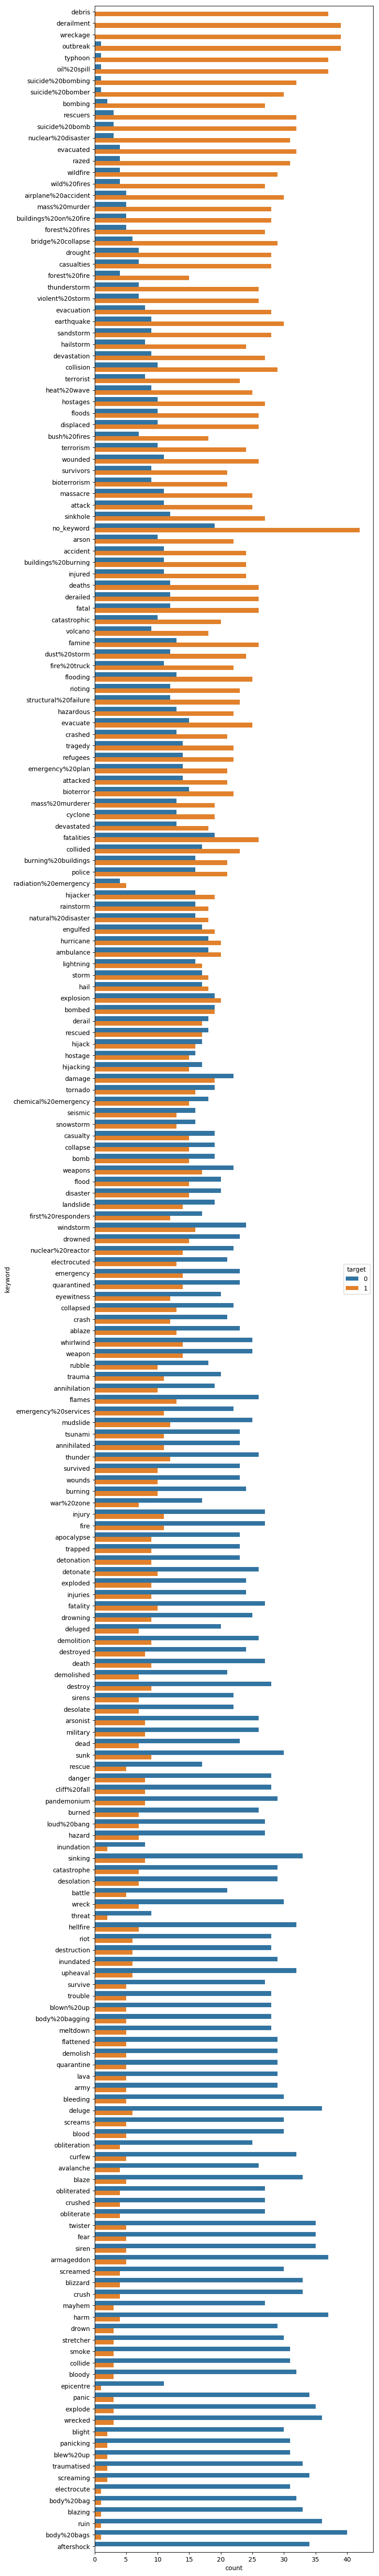

In [14]:
fig=plt.figure(figsize=(8,75) ,dpi=100)
sns.countplot(y=df_train.sort_values(by='target_mean' , ascending=False).keyword , hue=df_train.target )

Meta Features

* `word_count` number of words in text
* `unique_word_count` number of unique words in text
* `stop_word_count` number of stop words in text
* `url_count` number of urls in text
* `mean_word_length` average character count in words
* `char_count` number of characters in text
* `punctuation_count` number of punctuations in text
* `hashtag_count` number of hashtags (**#**) in text
* `mention_count` number of mentions (**@**) in text

In [15]:
df_train['word_count']=df_train['text'].apply(lambda x:len(x.split(' ')))
df_test['word_count']=df_test['text'].apply(lambda x:len(x.split(' ')))

####################################

df_train['unique_word_count']=df_train['text'].apply(lambda x:len(set(str(x).split(' '))))
df_test['unique_word_count']=df_test['text'].apply(lambda x:len(set(str(x).split(' '))))


#######################################

df_train['word_count']=df_train['text'].apply(lambda x:len(x.split(' ')))
df_test['word_count']=df_test['text'].apply(lambda x:len(x.split(' ')))

####################################

df_train['unique_word_count']=df_train['text'].apply(lambda x:len(set(str(x).split(' '))))
df_test['unique_word_count']=df_test['text'].apply(lambda x:len(set(str(x).split(' '))))


#######################################


df_train['stop_word_count']=df_train['text'].apply(lambda x:len(set(x.lower().split())&STOPWORDS))
df_test['stop_word_count']=df_test['text'].apply(lambda x:len(set(x.lower().split())&STOPWORDS))


###########################################

df_train['url_count']=df_train['text'].apply(lambda x : len(re.findall(r'(https?://[^\s]+)', x)))
df_test['url_count']=df_test['text'].apply(lambda x : len(re.findall(r'(https?://[^\s]+)', x)))

###########################################

df_train['mean_word_length']=df_train['text'].apply(lambda x : np.mean([len(w) for w in x.split()]))
df_test['mean_word_length']=df_test['text'].apply(lambda x : np.mean([len(w) for w in x.split()]))

############################################

df_train['char_count'] = df_train['text'].apply(lambda x: len(str(x)))
df_test['char_count'] = df_test['text'].apply(lambda x: len(str(x)))
############################################

df_train['punctuation_count'] = df_train['text'].apply(lambda x: len([char for char in x if char in string.punctuation]))
df_test['punctuation_count'] = df_test['text'].apply(lambda x: len([char for char in x if char in string.punctuation]))

############################################

df_train['hashtag_count'] = df_train['text'].apply(lambda x: Counter(x)['#'])
df_test['hashtag_count'] = df_test['text'].apply(lambda x: Counter(x)['#'])

############################################

df_train['mention_count'] = df_train['text'].apply(lambda x: Counter(x)['@'])
df_test['mention_count'] = df_test['text'].apply(lambda x: Counter(x)['@'])




In [16]:
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
                'char_count', 'punctuation_count', 'hashtag_count', 'mention_count']

In [17]:
# sns.displot(df_train, x="word_count", hue="target" , kind='kde')

In [18]:
# fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES),figsize=(20, 50), dpi=100)

# for  i,feature in enumerate(METAFEATURES):
#     sns.kdeplot(data=df_train,x=feature, hue='target',  ax=axes[i][0])
    
#     sns.kdeplot(data=df_train,x=feature,  ax=axes[i][1])
#     sns.kdeplot(data=df_test,x=feature, ax=axes[i][1])
    
#     for j in range(2):
#         axes[i][j].set_xlabel('')
        
#     axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
#     axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)
    

# plt.show()
    

It seems that train and test data set are from same sample 

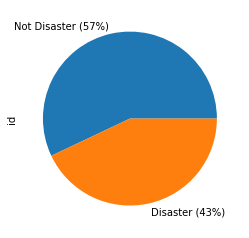

In [19]:
df_train.groupby('target').count()['id'].plot(kind='pie', labels=['Not Disaster (57%)', 'Disaster (43%)'])

In [20]:
DISASTER_TWEETS = df_train['target'] == 1

In [21]:
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
#     ngrams = zip(*[token[i:] for i in range(n_gram)])
    ngram_sentence = ngrams(token, n_gram)
    return [' '.join(ngram) for ngram in ngram_sentence]

In [22]:
N = 100

# Unigrams
disaster_unigrams = defaultdict(int)
nondisaster_unigrams = defaultdict(int)

for tweet in df_train[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet):
        disaster_unigrams[word] += 1
        
        
for tweet in df_train[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet):
        nondisaster_unigrams[word] += 1
        
df_disaster_unigrams = pd.DataFrame(sorted(disaster_unigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_unigrams = pd.DataFrame(sorted(nondisaster_unigrams.items(), key=lambda x: x[1])[::-1])



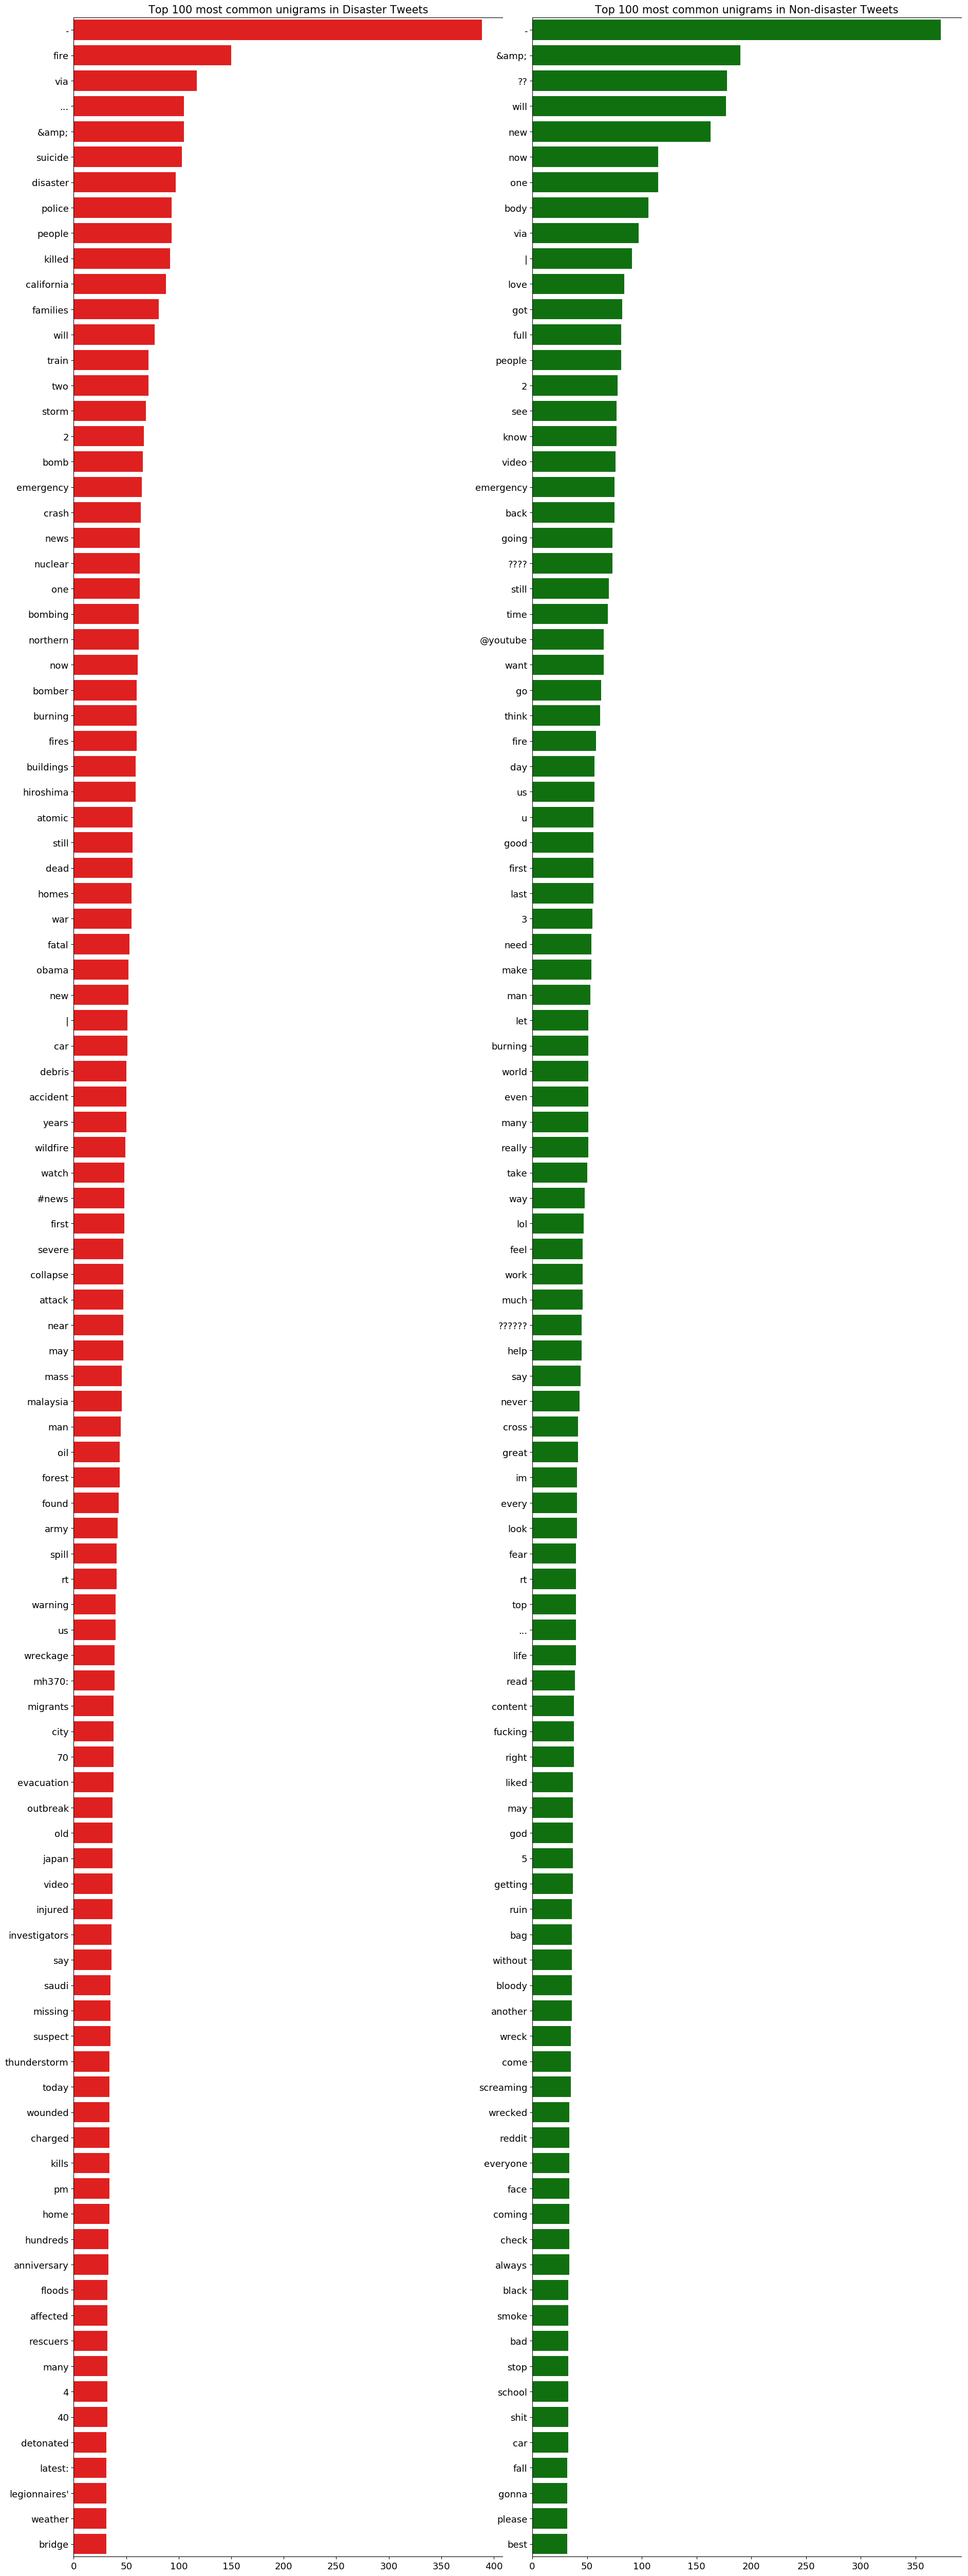

In [23]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 50), dpi=100)
plt.tight_layout()

sns.barplot(y=df_disaster_unigrams[0].values[:N], x=df_disaster_unigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nondisaster_unigrams[0].values[:N], x=df_nondisaster_unigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common unigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common unigrams in Non-disaster Tweets', fontsize=15)

plt.show()

In [24]:
disaster_bigrams = defaultdict(int)
nondisaster_bigrams = defaultdict(int)

for tweet in df_train[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        disaster_bigrams[word] += 1
        
for tweet in df_train[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        nondisaster_bigrams[word] += 1
        
df_disaster_bigrams = pd.DataFrame(sorted(disaster_bigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_bigrams = pd.DataFrame(sorted(nondisaster_bigrams.items(), key=lambda x: x[1])[::-1])



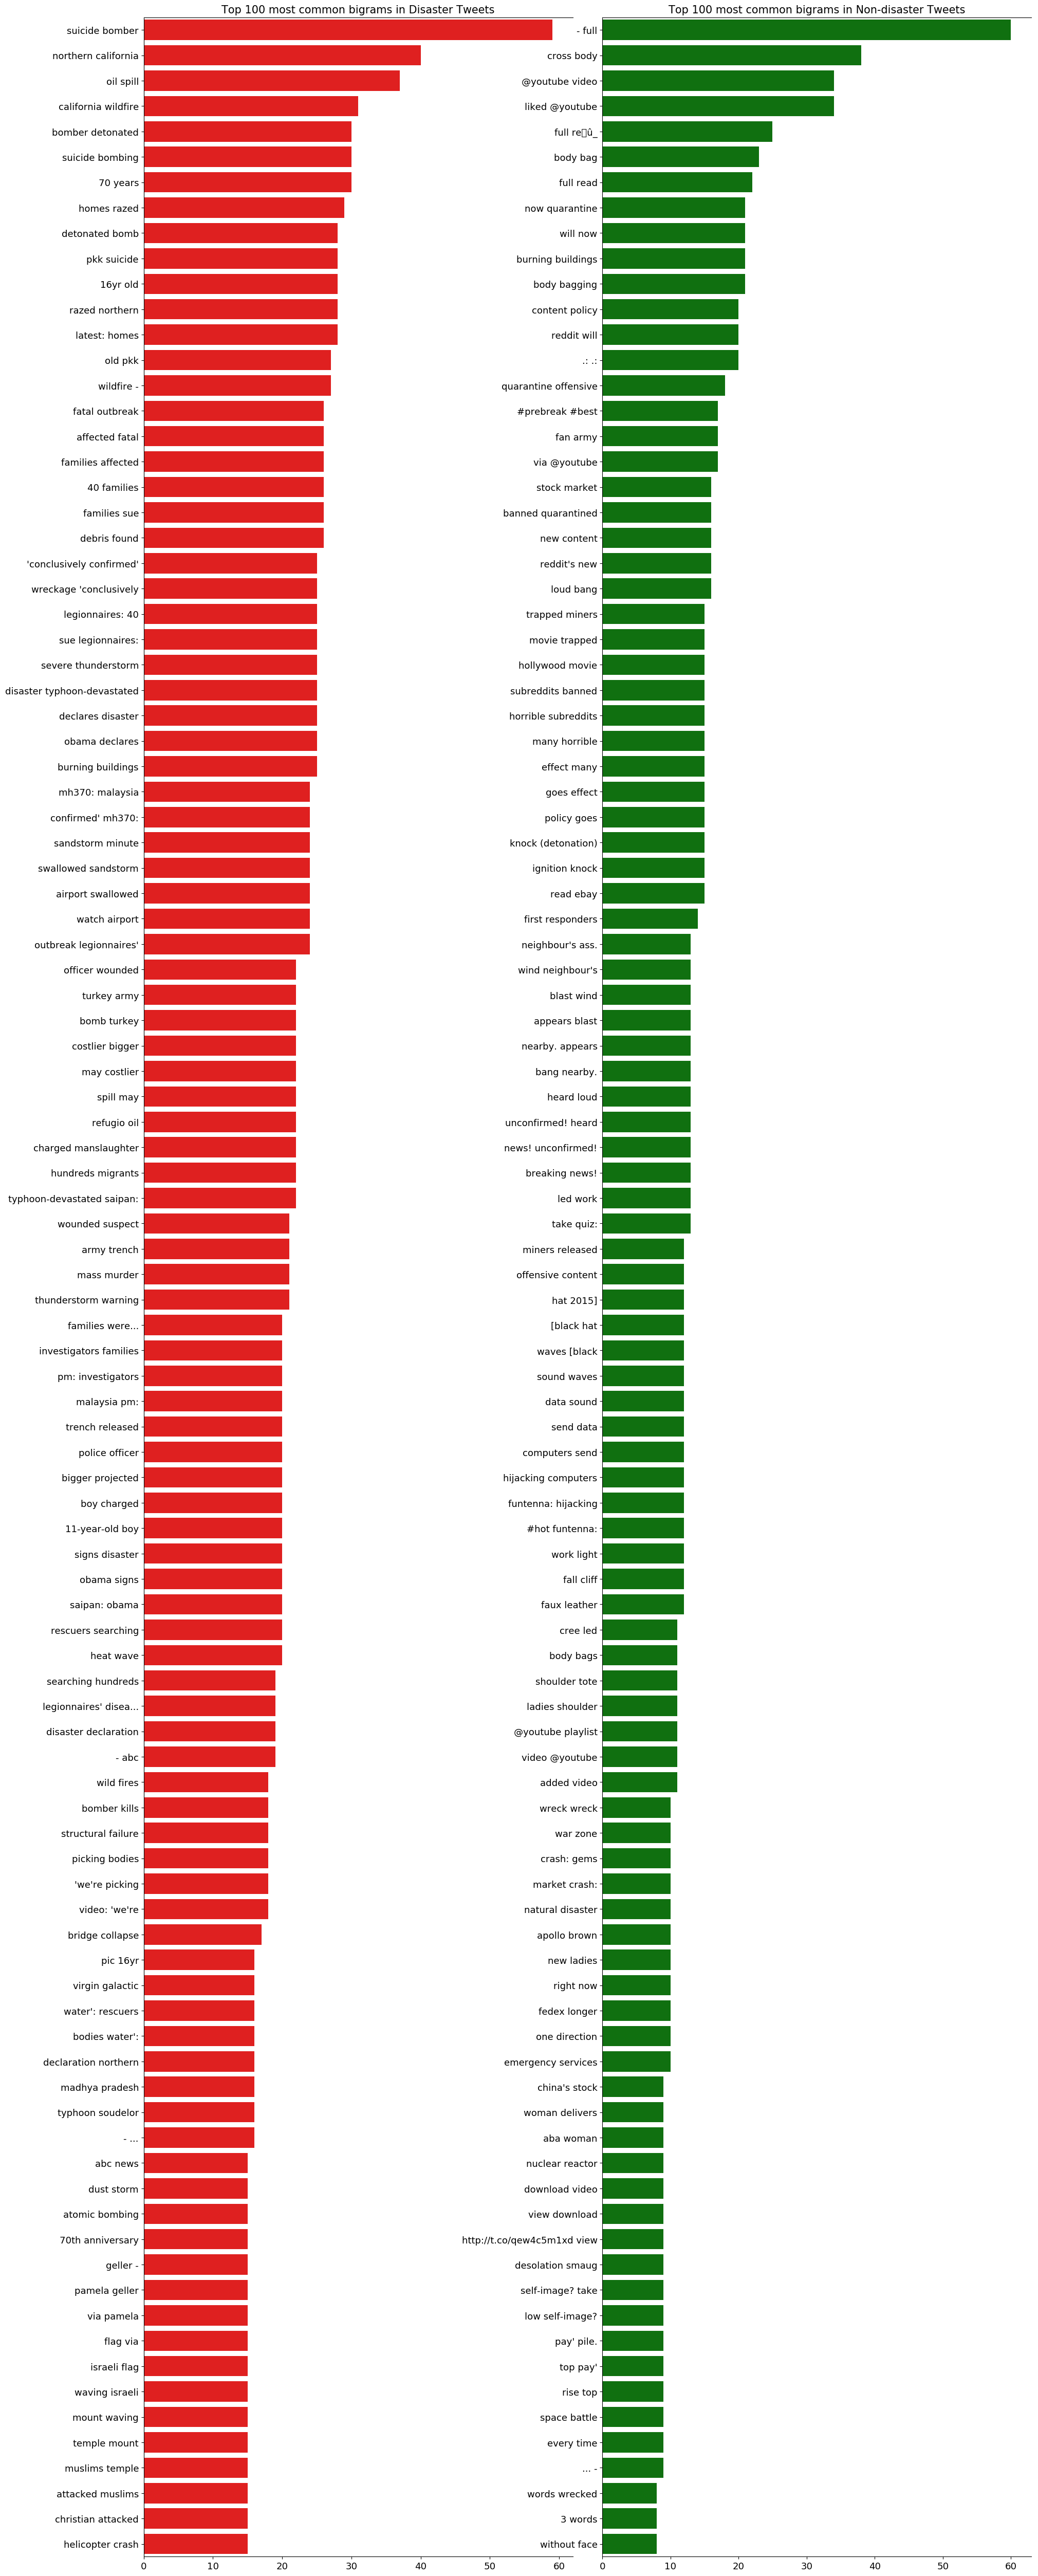

In [25]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 50), dpi=100)
plt.tight_layout()

sns.barplot(y=df_disaster_bigrams[0].values[:N], x=df_disaster_bigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nondisaster_bigrams[0].values[:N], x=df_nondisaster_bigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common bigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common bigrams in Non-disaster Tweets', fontsize=15)

plt.show()

In [26]:
%%time

glove_embeddings = np.load('../input/pickled-glove840b300d-for-10sec-loading/glove.840B.300d.pkl', allow_pickle=True)


CPU times: user 5.7 s, sys: 2.83 s, total: 8.52 s
Wall time: 28.2 s


In [27]:
fasttext_embeddings = np.load('../input/pickled-crawl300d2m-for-kernel-competitions/crawl-300d-2M.pkl', allow_pickle=True)

In [28]:
len(glove_embeddings.keys())

2196008

In [29]:
df_train.text[0:2]

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
Name: text, dtype: object

In [30]:
def build_vocab(X):
    
    tweets = X.apply(lambda s: s.split()).values   
    vocab = {}
    
    for tweet in tweets:
        for word in tweet:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1                
    return vocab


def check_embeddings_coverage(X, embeddings):
    
    vocab = build_vocab(X)    
    covered = {}
    oov = {}    
    n_covered = 0
    n_oov = 0
    
    for word in vocab:
        try:
            covered[word] = embeddings[word]
            n_covered += vocab[word]
        except:
            oov[word] = vocab[word]
            n_oov += vocab[word]
            
    vocab_coverage = len(covered) / len(vocab)
    text_coverage = (n_covered / (n_covered + n_oov))
    
    sorted_oov = sorted(oov.items(), key=operator.itemgetter(1))[::-1]
    return sorted_oov, vocab_coverage, text_coverage

train_glove_oov, train_glove_vocab_coverage, train_glove_text_coverage = check_embeddings_coverage(df_train['text'], glove_embeddings)
test_glove_oov, test_glove_vocab_coverage, test_glove_text_coverage = check_embeddings_coverage(df_test['text'], glove_embeddings)
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(train_glove_vocab_coverage, train_glove_text_coverage))
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Test Set'.format(test_glove_vocab_coverage, test_glove_text_coverage))

train_fasttext_oov, train_fasttext_vocab_coverage, train_fasttext_text_coverage = check_embeddings_coverage(df_train['text'], fasttext_embeddings)
test_fasttext_oov, test_fasttext_vocab_coverage, test_fasttext_text_coverage = check_embeddings_coverage(df_test['text'], fasttext_embeddings)
print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(train_fasttext_vocab_coverage, train_fasttext_text_coverage))
print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Test Set'.format(test_fasttext_vocab_coverage, test_fasttext_text_coverage))

GloVe Embeddings cover 52.06% of vocabulary and 82.68% of text in Training Set
GloVe Embeddings cover 57.21% of vocabulary and 81.85% of text in Test Set
FastText Embeddings cover 51.52% of vocabulary and 81.84% of text in Training Set
FastText Embeddings cover 56.55% of vocabulary and 81.12% of text in Test Set


In [31]:
test_glove_oov

[('\x89Û_', 28),
 ('\x89ÛÒ', 27),
 ('\x89ÛÓ', 16),
 ('@Change', 14),
 ('Latest:', 13),
 ('w/', 13),
 ("'I", 13),
 ('MH370:', 12),
 ('#Hiroshima', 12),
 ('Photo:', 12),
 ('#prebreak', 11),
 ("pay'", 11),
 ('Horse...', 11),
 ('Forest:', 11),
 ('Crash:', 10),
 ("China's", 10),
 ("neighbour's", 10),
 ('Unconfirmed!', 10),
 ('news!', 10),
 ('quiz:', 10),
 ("they're", 10),
 ('re\x89Û_', 10),
 ("isn't", 10),
 ("Legionnaires'", 9),
 ('2015]', 9),
 ('[Black', 9),
 ('Funtenna:', 9),
 ('t...', 9),
 ("he's", 9),
 ('Rubble?', 8),
 ('a...', 8),
 ('(Detonation)', 8),
 ('invoices.', 8),
 ('#???', 8),
 ('#??', 8),
 ("'The", 8),
 ('the...', 8),
 ("there's", 8),
 ("Confirmed'", 7),
 ("'Conclusively", 7),
 ('Typhoon-Devastated', 7),
 ("won't", 7),
 ("i'm", 7),
 ('it!', 7),
 ("ain't", 7),
 ("wouldn't", 7),
 ("I'M", 7),
 ("Let's", 7),
 ('\x89ÛÏWhen', 6),
 ('horror:', 6),
 ('MP:', 6),
 ('bestnaijamade', 6),
 ("Reddit's", 6),
 ('disea...', 6),
 ('Legionnaires:', 6),
 ('Canaanites?', 6),
 ('attack:', 6),
 ("ha

In [32]:
def clean(tweet):
    tweet=re.sub(r'x89Û_','',tweet)
    tweet=re.sub(r'MH370','Malaysia Airlines Flight 370',tweet)
    tweet=re.sub(r'\x89ÛÒ','',tweet) 
    tweet=re.sub(r're\x89Û_','',tweet) 
    tweet=re.sub(r'\x89Û_','',tweet) 
    tweet=re.sub(r'\x89ÛÓ','',tweet) 
    tweet=re.sub(r'w/','',tweet) 
    tweet=re.sub(r'#GBBO','The Great British Bake Off',tweet) 
    tweet=re.sub(r'don\x89Ûªt','do not',tweet) 
    tweet=re.sub(r"crematoria","crematoria",tweet) 
    tweet=re.sub(r'UTC2015-08-05','UTC 2015-08-05',tweet) 
    tweet=re.sub(r'\x89ÛÏWhen','When',tweet) 
    tweet=re.sub(r'#ISIS','Islamic State',tweet) 
    tweet=re.sub(r'&gt;&gt;','greater than',tweet) 
    tweet=re.sub(r'Time 2015-08-06','',tweet) 
    tweet=re.sub(r"he's",'he is',tweet) 
    tweet=re.sub(r"we're",'we are',tweet) 
    tweet=re.sub(r"Typhoon-Devastated",'Typhoon Devastated',tweet) 
    tweet=re.sub(r"Reddit's",'Reddit is',tweet) 
    tweet=re.sub(r"That's",'that is',tweet) 
    tweet=re.sub(r"there's",'there is',tweet) 
    tweet=re.sub(r"won't",'will not',tweet)              
    tweet=re.sub(r"they're",'they are',tweet)              
    tweet=re.sub(r"she's",'she is',tweet) 
    tweet=re.sub(r"ain't",'am not',tweet)  
    tweet=re.sub(r"Sensor-Senso",'Sensor Senso',tweet)  
    tweet=re.sub(r"haven't",'have not',tweet) 
    tweet=re.sub(r"hasn't",'has not',tweet)  
    tweet=re.sub(r"let's",'let is',tweet) 
    
        # Urls
    tweet = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", tweet)
    
    # Words with punctuations and special characters
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`"
    for p in punctuations:
        tweet = tweet.replace(p, f' {p} ')
    
    return tweet

In [33]:
df_train['text_cleaned'] = df_train['text'].apply(lambda s : clean(s))
df_test['text_cleaned'] = df_test['text'].apply(lambda s : clean(s))

train_glove_oov, train_glove_vocab_coverage, train_glove_text_coverage = check_embeddings_coverage(df_train['text_cleaned'], glove_embeddings)
test_glove_oov, test_glove_vocab_coverage, test_glove_text_coverage = check_embeddings_coverage(df_test['text_cleaned'], glove_embeddings)
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(train_glove_vocab_coverage, train_glove_text_coverage))
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Test Set'.format(test_glove_vocab_coverage, test_glove_text_coverage))

train_fasttext_oov, train_fasttext_vocab_coverage, train_fasttext_text_coverage = check_embeddings_coverage(df_train['text_cleaned'], fasttext_embeddings)
test_fasttext_oov, test_fasttext_vocab_coverage, test_fasttext_text_coverage = check_embeddings_coverage(df_test['text_cleaned'], fasttext_embeddings)
print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(train_fasttext_vocab_coverage, train_fasttext_text_coverage))
print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Test Set'.format(test_fasttext_vocab_coverage, test_fasttext_text_coverage))

GloVe Embeddings cover 80.86% of vocabulary and 96.44% of text in Training Set
GloVe Embeddings cover 84.29% of vocabulary and 96.25% of text in Test Set
FastText Embeddings cover 80.95% of vocabulary and 96.46% of text in Training Set
FastText Embeddings cover 84.25% of vocabulary and 96.25% of text in Test Set


In [34]:
del glove_embeddings, fasttext_embeddings, train_glove_oov, test_glove_oov, train_fasttext_oov, test_fasttext_oov
gc.collect()

37696

# Cross-validation

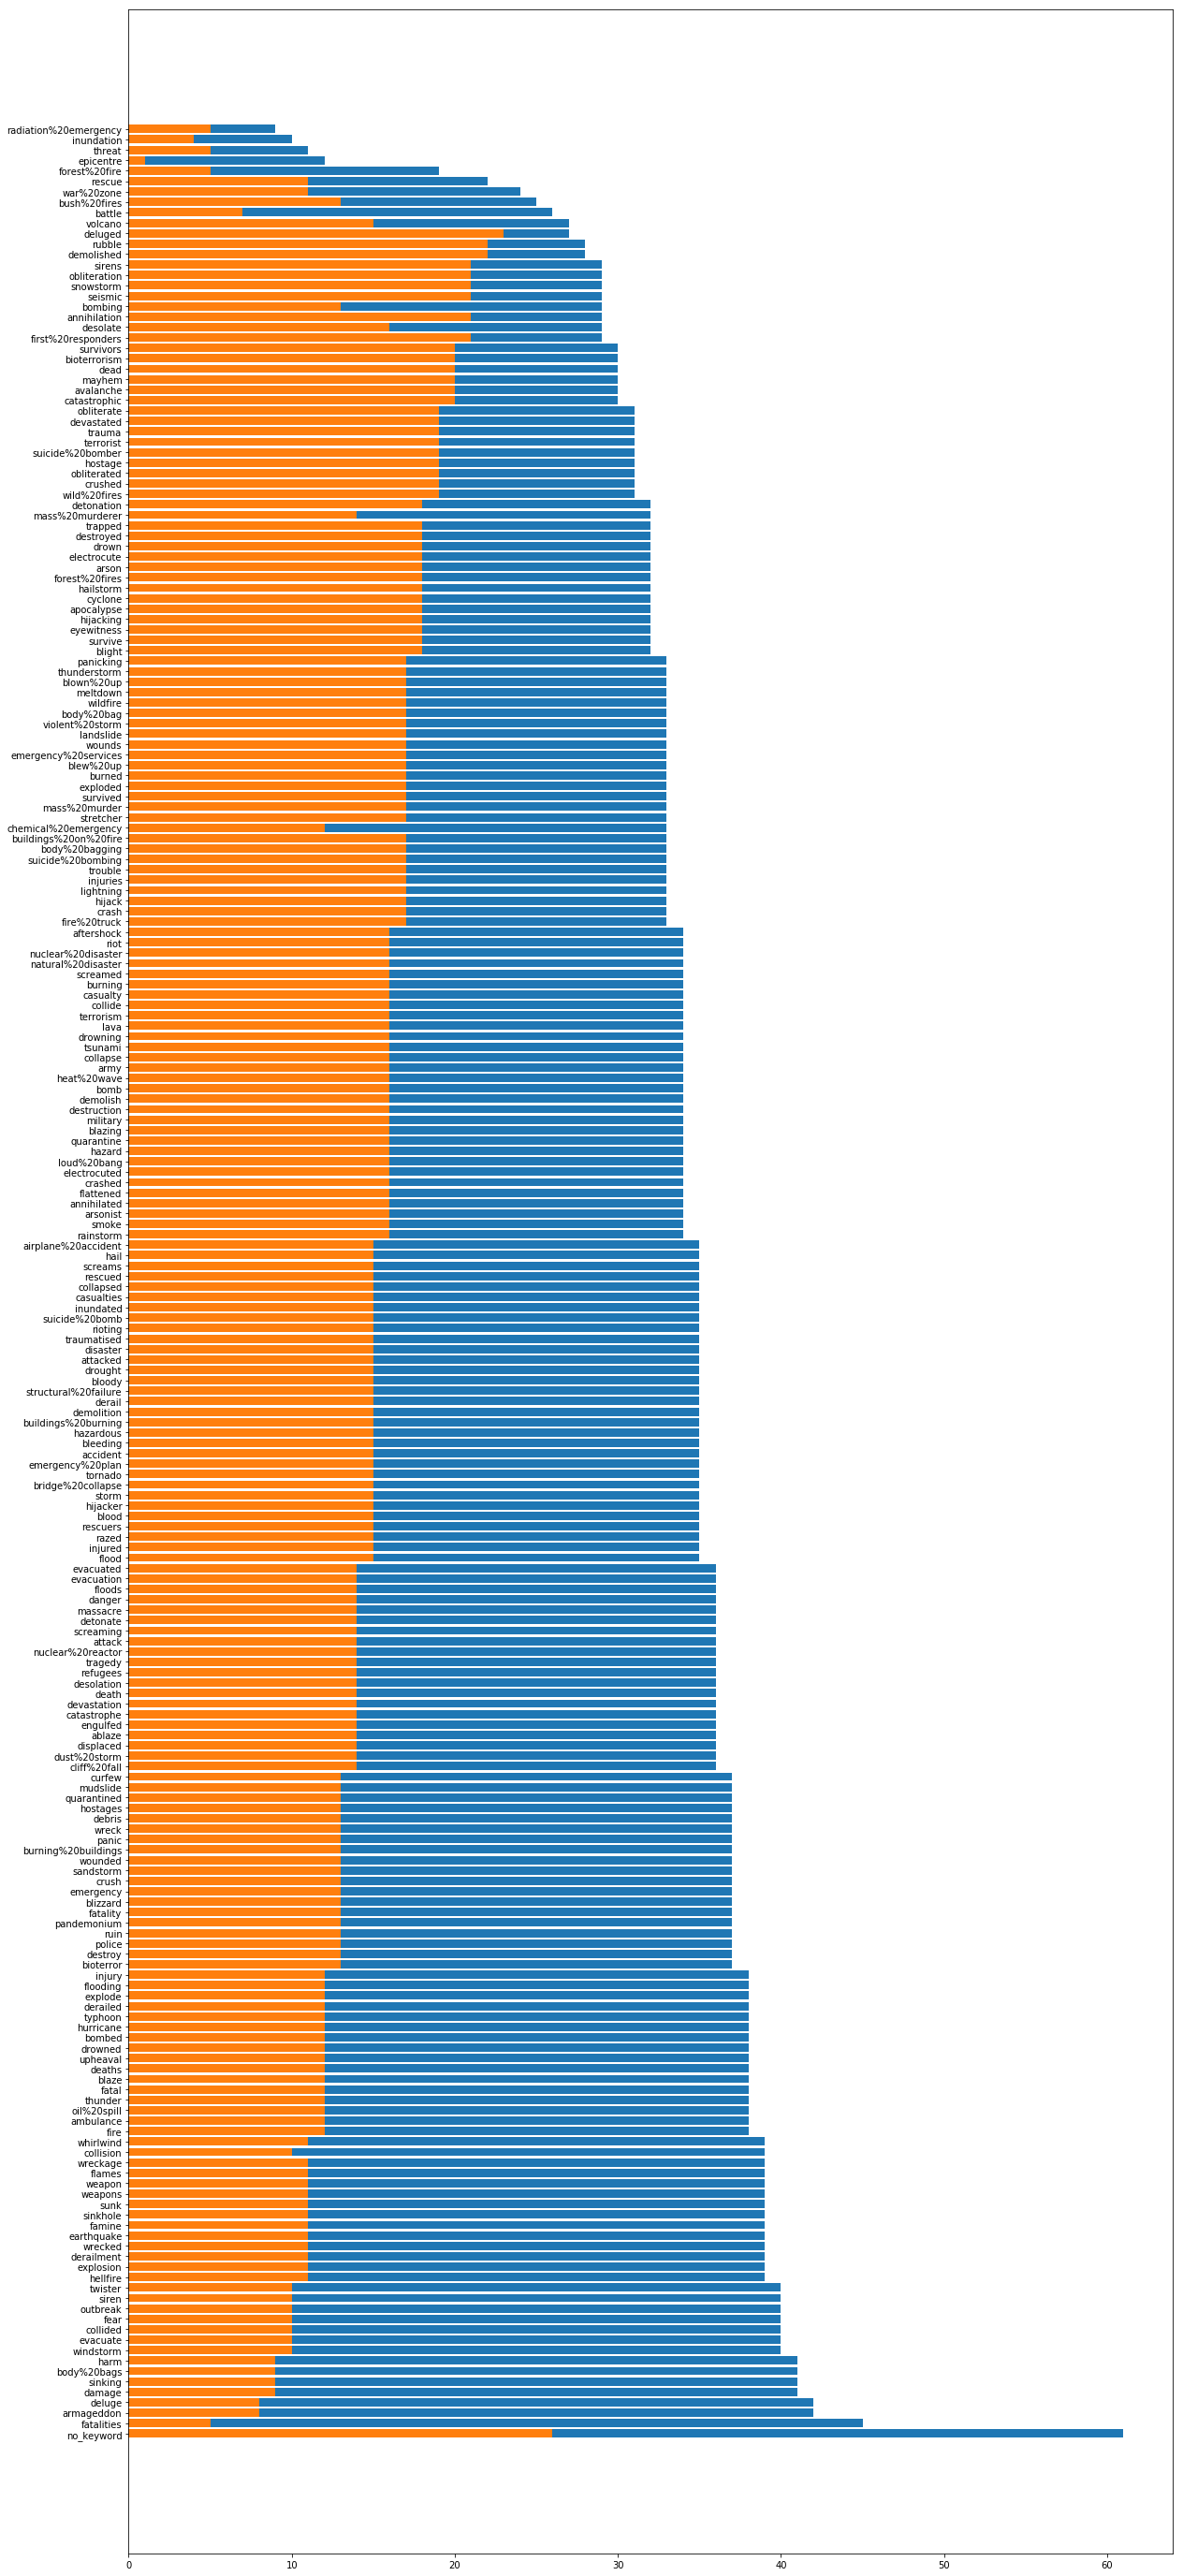

In [35]:
fig , axes=plt.subplots(figsize=(20,50))
plt.barh(y=df_train.keyword.value_counts().index , width=df_train.keyword.value_counts().values)
plt.barh(y=df_test.keyword.value_counts().index , width=df_test.keyword.value_counts().values)
plt.show()

In [36]:
# from sklearn import feature_extraction, linear_model, model_selection, preprocessing
# countvec=feature_extraction.text.CountVectorizer()
# train_vectors=countvec.fit_transform(df_train.text_cleaned)
# test_vectors = countvec.transform(df_test.text_cleaned)
# from sklearn.naive_bayes import MultinomialNB
# clf = MultinomialNB()
# scores = model_selection.cross_val_score(clf, train_vectors, df_train["target"], cv=3, scoring="f1"  )
# scores
# clf.fit(train_vectors, df_train["target"])
# sample_submission = pd.read_csv("E:/Science/DATA/NLP-disaster-tweets/sample_submission.csv")

In [37]:
df_mislabeled = df_train.groupby(['text']).nunique().sort_values(by='target', ascending=False)
df_mislabeled = df_mislabeled[df_mislabeled['target'] > 1]['target']
df_mislabeled.index.tolist()

['like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit',
 'Hellfire! We don\x89Ûªt even want to think about it or mention it so let\x89Ûªs not do anything that leads to it #islam!',
 "The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'",
 'In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!',
 'To fight bioterrorism sir.',
 'Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE',
 '#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption',
 '#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect',
 'He came to a land which was engulfed in tribal war and turned it into a land 

In [38]:
df_train['target_relabeled'] = df_train['target'].copy() 

df_train.loc[df_train['text'] == 'like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit', 'target_relabeled'] = 0
df_train.loc[df_train['text'] == 'Hellfire is surrounded by desires so be careful and donÛªt let your desires control you! #Afterlife', 'target_relabeled'] = 0
df_train.loc[df_train['text'] == 'To fight bioterrorism sir.', 'target_relabeled'] = 0
df_train.loc[df_train['text'] == '.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4', 'target_relabeled'] = 1
df_train.loc[df_train['text'] == 'CLEARED:incident with injury:I-495  inner loop Exit 31 - MD 97/Georgia Ave Silver Spring', 'target_relabeled'] = 1
df_train.loc[df_train['text'] == '#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption', 'target_relabeled'] = 0
df_train.loc[df_train['text'] == 'In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!', 'target_relabeled'] = 0
df_train.loc[df_train['text'] == 'Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE', 'target_relabeled'] = 1
df_train.loc[df_train['text'] == 'RT NotExplained: The only known image of infamous hijacker D.B. Cooper. http://t.co/JlzK2HdeTG', 'target_relabeled'] = 1
df_train.loc[df_train['text'] == "Mmmmmm I'm burning.... I'm burning buildings I'm building.... Oooooohhhh oooh ooh...", 'target_relabeled'] = 0
df_train.loc[df_train['text'] == "wowo--=== 12000 Nigerian refugees repatriated from Cameroon", 'target_relabeled'] = 0
df_train.loc[df_train['text'] == "He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam", 'target_relabeled'] = 0
df_train.loc[df_train['text'] == "Hellfire! We donÛªt even want to think about it or mention it so letÛªs not do anything that leads to it #islam!", 'target_relabeled'] = 0
df_train.loc[df_train['text'] == "The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'", 'target_relabeled'] = 0
df_train.loc[df_train['text'] == "Caution: breathing may be hazardous to your health.", 'target_relabeled'] = 1
df_train.loc[df_train['text'] == "I Pledge Allegiance To The P.O.P.E. And The Burning Buildings of Epic City. ??????", 'target_relabeled'] = 0
df_train.loc[df_train['text'] == "#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect", 'target_relabeled'] = 0
df_train.loc[df_train['text'] == "that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time", 'target_relabeled'] = 0

In [39]:
K = 2
skf = StratifiedKFold(n_splits=K, random_state=SEED, shuffle=True)

DISASTER = df_train['target'] == 1
print('Whole Training Set Shape = {}'.format(df_train.shape))
print('Whole Training Set Unique keyword Count = {}'.format(df_train['keyword'].nunique()))
print('Whole Training Set Target Rate (Disaster) {}/{} (Not Disaster)'.format(df_train[DISASTER]['target_relabeled'].count(), df_train[~DISASTER]['target_relabeled'].count()))

for fold, (trn_idx, val_idx) in enumerate(skf.split(df_train['text_cleaned'], df_train['target']), 1):
    print('\nFold {} Training Set Shape = {} - Validation Set Shape = {}'.format(fold, df_train.loc[trn_idx, 'text_cleaned'].shape, df_train.loc[val_idx, 'text_cleaned'].shape))
    print('Fold {} Training Set Unique keyword Count = {} - Validation Set Unique keyword Count = {}'.format(fold, df_train.loc[trn_idx, 'keyword'].nunique(), df_train.loc[val_idx, 'keyword'].nunique()))    

Whole Training Set Shape = (7613, 17)
Whole Training Set Unique keyword Count = 222
Whole Training Set Target Rate (Disaster) 3271/4342 (Not Disaster)

Fold 1 Training Set Shape = (3806,) - Validation Set Shape = (3807,)
Fold 1 Training Set Unique keyword Count = 222 - Validation Set Unique keyword Count = 222

Fold 2 Training Set Shape = (3807,) - Validation Set Shape = (3806,)
Fold 2 Training Set Unique keyword Count = 222 - Validation Set Unique keyword Count = 222


In [40]:
class ClassificationReport(Callback):
    
    def __init__(self, train_data=(), validation_data=()):
        super(Callback, self).__init__()
        
        self.X_train, self.y_train = train_data
        self.train_precision_scores = []
        self.train_recall_scores = []
        self.train_f1_scores = []
        
        self.X_val, self.y_val = validation_data
        self.val_precision_scores = []
        self.val_recall_scores = []
        self.val_f1_scores = [] 
               
    def on_epoch_end(self, epoch, logs={}):
        train_predictions = np.round(self.model.predict(self.X_train, verbose=0))        
        train_precision = precision_score(self.y_train, train_predictions, average='macro')
        train_recall = recall_score(self.y_train, train_predictions, average='macro')
        train_f1 = f1_score(self.y_train, train_predictions, average='macro')
        self.train_precision_scores.append(train_precision)        
        self.train_recall_scores.append(train_recall)
        self.train_f1_scores.append(train_f1)
        
        val_predictions = np.round(self.model.predict(self.X_val, verbose=0))
        val_precision = precision_score(self.y_val, val_predictions, average='macro')
        val_recall = recall_score(self.y_val, val_predictions, average='macro')
        val_f1 = f1_score(self.y_val, val_predictions, average='macro')
        self.val_precision_scores.append(val_precision)        
        self.val_recall_scores.append(val_recall)        
        self.val_f1_scores.append(val_f1)
        
        print('\nEpoch: {} - Training Precision: {:.6} - Training Recall: {:.6} - Training F1: {:.6}'.format(epoch + 1, train_precision, train_recall, train_f1))
        print('Epoch: {} - Validation Precision: {:.6} - Validation Recall: {:.6} - Validation F1: {:.6}'.format(epoch + 1, val_precision, val_recall, val_f1))  

In [41]:
%%time

bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1', trainable=True)

CPU times: user 27.4 s, sys: 1.49 s, total: 28.9 s
Wall time: 31.5 s


In [42]:
class DisasterDetector:
    
    def __init__(self, bert_layer, max_seq_length=128, lr=0.0001, epochs=15, batch_size=32):
        
        # BERT and Tokenization params
        self.bert_layer = bert_layer
        
        self.max_seq_length = max_seq_length        
        vocab_file = self.bert_layer.resolved_object.vocab_file.asset_path.numpy()
        do_lower_case = self.bert_layer.resolved_object.do_lower_case.numpy()
        self.tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)
        
        # Learning control params
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        
        self.models = []
        self.scores = {}
        
        
    def encode(self, texts):
                
        all_tokens = []
        all_masks = []
        all_segments = []

        for text in texts:
            text = self.tokenizer.tokenize(text)
            text = text[:self.max_seq_length - 2]
            input_sequence = ['[CLS]'] + text + ['[SEP]']
            pad_len = self.max_seq_length - len(input_sequence)

            tokens = self.tokenizer.convert_tokens_to_ids(input_sequence)
            tokens += [0] * pad_len
            pad_masks = [1] * len(input_sequence) + [0] * pad_len
            segment_ids = [0] * self.max_seq_length

            all_tokens.append(tokens)
            all_masks.append(pad_masks)
            all_segments.append(segment_ids)

        return np.array(all_tokens), np.array(all_masks), np.array(all_segments)
    
    
    def build_model(self):
        
        input_word_ids = Input(shape=(self.max_seq_length,), dtype=tf.int32, name='input_word_ids')
        input_mask = Input(shape=(self.max_seq_length,), dtype=tf.int32, name='input_mask')
        segment_ids = Input(shape=(self.max_seq_length,), dtype=tf.int32, name='segment_ids')    
        
        pooled_output, sequence_output = self.bert_layer([input_word_ids, input_mask, segment_ids])   
        clf_output = sequence_output[:, 0, :]
        out = Dense(1, activation='sigmoid')(clf_output)
        
        model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
        optimizer = SGD(learning_rate=self.lr, momentum=0.8)
        model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        
        return model
    
    
    def train(self, X):
        
        for fold, (trn_idx, val_idx) in enumerate(skf.split(X['text_cleaned'], X['keyword'])):
            
            print('\nFold {}\n'.format(fold))
        
            X_trn_encoded = self.encode(X.loc[trn_idx, 'text_cleaned'].str.lower())
            y_trn = X.loc[trn_idx, 'target_relabeled']
            X_val_encoded = self.encode(X.loc[val_idx, 'text_cleaned'].str.lower())
            y_val = X.loc[val_idx, 'target_relabeled']
        
            # Callbacks
            metrics = ClassificationReport(train_data=(X_trn_encoded, y_trn), validation_data=(X_val_encoded, y_val))
            
            # Model
            model = self.build_model()        
            model.fit(X_trn_encoded, y_trn, validation_data=(X_val_encoded, y_val), callbacks=[metrics], epochs=self.epochs, batch_size=self.batch_size)
            
            self.models.append(model)
            self.scores[fold] = {
                'train': {
                    'precision': metrics.train_precision_scores,
                    'recall': metrics.train_recall_scores,
                    'f1': metrics.train_f1_scores                    
                },
                'validation': {
                    'precision': metrics.val_precision_scores,
                    'recall': metrics.val_recall_scores,
                    'f1': metrics.val_f1_scores                    
                }
            }
                    
                
    def plot_learning_curve(self):
        
        fig, axes = plt.subplots(nrows=K, ncols=2, figsize=(20, K * 6), dpi=100)
    
        for i in range(K):
            
            # Classification Report curve
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.models[i].history.history['val_accuracy'], ax=axes[i][0], label='val_accuracy')
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.scores[i]['validation']['precision'], ax=axes[i][0], label='val_precision')
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.scores[i]['validation']['recall'], ax=axes[i][0], label='val_recall')
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.scores[i]['validation']['f1'], ax=axes[i][0], label='val_f1')        

            axes[i][0].legend() 
            axes[i][0].set_title('Fold {} Validation Classification Report'.format(i), fontsize=14)

            # Loss curve
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.models[0].history.history['loss'], ax=axes[i][1], label='train_loss')
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.models[0].history.history['val_loss'], ax=axes[i][1], label='val_loss')

            axes[i][1].legend() 
            axes[i][1].set_title('Fold {} Train / Validation Loss'.format(i), fontsize=14)

            for j in range(2):
                axes[i][j].set_xlabel('Epoch', size=12)
                axes[i][j].tick_params(axis='x', labelsize=12)
                axes[i][j].tick_params(axis='y', labelsize=12)

        plt.show()
        
        
    def predict(self, X):
        
        X_test_encoded = self.encode(X['text_cleaned'].str.lower())
        y_pred = np.zeros((X_test_encoded[0].shape[0], 1))

        for model in self.models:
            y_pred += model.predict(X_test_encoded) / len(self.models)

        return y_pred

In [43]:
#from bert import tokenization
import os
os.getcwd()


'/kaggle/working'

In [44]:
clf = DisasterDetector(bert_layer, max_seq_length=128, lr=0.0001, epochs=10, batch_size=32)

clf.train(df_train)


Fold 0

Train on 3747 samples, validate on 3866 samples
Epoch 1/10
3744/3747 [============================>.] - ETA: 0s - loss: 0.6817 - accuracy: 0.5684
Epoch: 1 - Training Precision: 0.70721 - Training Recall: 0.647076 - Training F1: 0.640167
Epoch: 1 - Validation Precision: 0.705369 - Validation Recall: 0.64912 - Validation F1: 0.643291
3747/3747 [==============================] - 122s 32ms/sample - loss: 0.6817 - accuracy: 0.5682 - val_loss: 0.6203 - val_accuracy: 0.6847
Epoch 2/10
3744/3747 [============================>.] - ETA: 0s - loss: 0.5736 - accuracy: 0.7308
Epoch: 2 - Training Precision: 0.774115 - Training Recall: 0.739196 - Training F1: 0.744023
Epoch: 2 - Validation Precision: 0.759768 - Validation Recall: 0.72617 - Validation F1: 0.730322
3747/3747 [==============================] - 104s 28ms/sample - loss: 0.5734 - accuracy: 0.7310 - val_loss: 0.5386 - val_accuracy: 0.7491
Epoch 3/10
3744/3747 [============================>.] - ETA: 0s - loss: 0.4931 - accuracy: 0.7

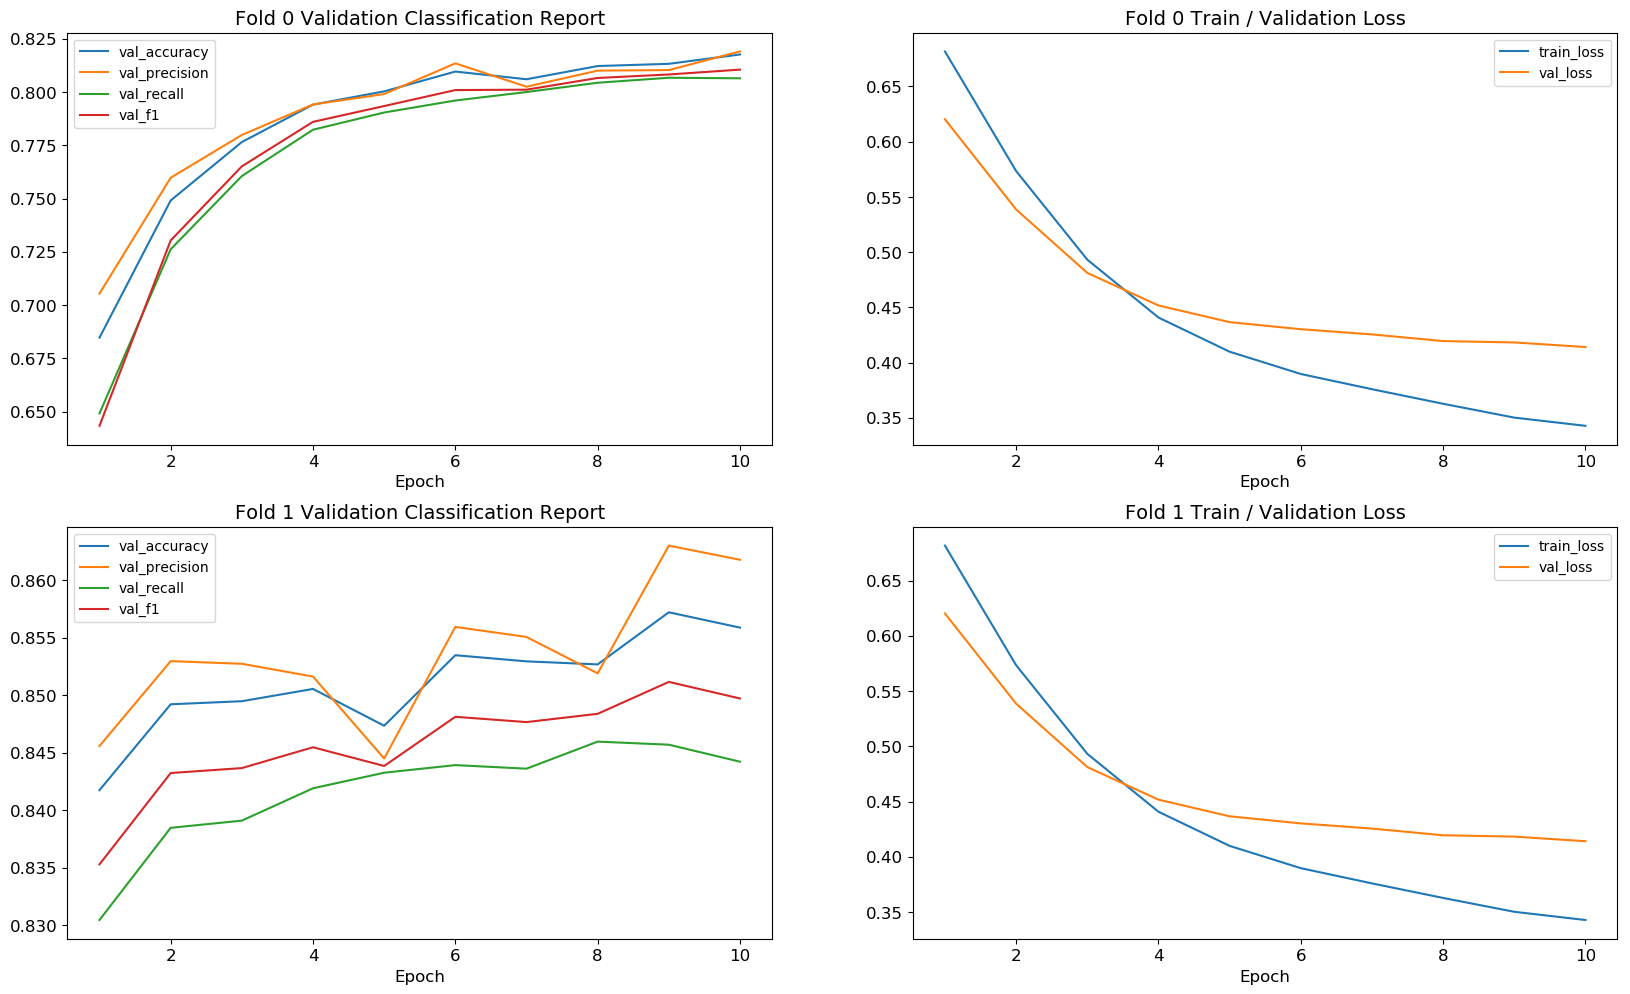

In [45]:

clf.plot_learning_curve()

In [46]:
y_pred = clf.predict(df_test)

model_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
model_submission['target'] = np.round(y_pred).astype('int')
model_submission.to_csv('model_submission.csv', index=False)
model_submission.describe()

,id,target
count,3263.000000,3263.000000
mean,5427.152927,0.353049
std,3146.427221,0.477991
min,0.000000,0.000000
25%,2683.000000,0.000000
50%,5500.000000,0.000000
75%,8176.000000,1.000000
max,10875.000000,1.000000
